In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyccl as ccl
from scipy.optimize import minimize
import matplotlib.cm as cm

In [2]:
dn = np.genfromtxt("full_maskstrict_I2mJy_q5.csv", names=True, delimiter=',')
dc = np.genfromtxt("data_szymon.csv", names=True, delimiter=',')

<ErrorbarContainer object of 3 artists>

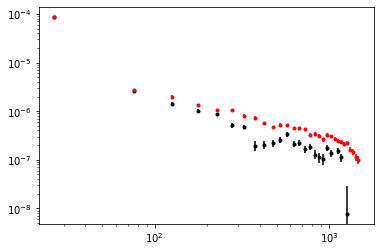

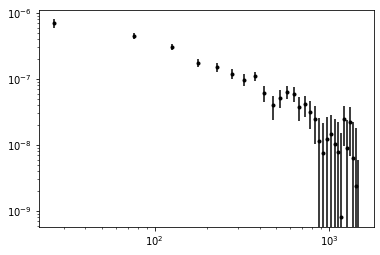

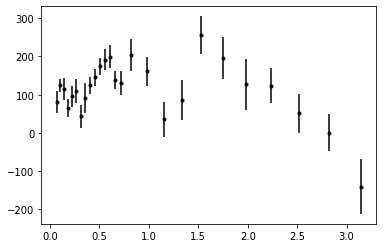

In [3]:
plt.figure()
plt.errorbar(dc['l'], dc['Cl_gg']-dc['nl_gg'], yerr=dc['error_gg'], fmt='k.')
plt.errorbar(dc['l'], dc['Cl_gg_raw']-dc['nl_gg'], yerr=dc['error_gg'], fmt='r.')
plt.loglog()
plt.figure()
plt.errorbar(dc['l'], dc['Cl_gk'], yerr=dc['error_gk'], fmt='k.')
plt.loglog()
plt.figure()
plt.errorbar(dn['z'], dn['dNdz_b'], yerr=dn['dNdz_b_err'], fmt='k.')


In [4]:
def gaumix(z, qs, ms, ss):
    def gau(z, q, m, s):
        return q*np.exp(-0.5*((m-z)/s)**2)/np.sqrt(2*np.pi*s**2)

    wz = np.zeros_like(z)
    for q, m, s in zip(qs, ms, ss):
        wz += gau(z, q, m, s)
    return wz

def get_params(p):
    ngau = p.size // 3
    pp = np.array(p).reshape([3, ngau])
    # p_i = q_i / A
    ps_m1 = pp[0, 1:] / pp[0, 0]
    # p_N = 1 - sum_{i<N} p_i
    p_last = 1-np.sum(ps_m1)
    # q_i = A * p_i
    qs = np.concatenate((ps_m1, np.array([p_last])))*pp[0, 0]
    pp[0, :] = qs
    return pp[0], pp[1], pp[2]

def like(p):
    qs, ms, ss = get_params(p)
    if np.any(qs < 0) or np.any(ms < 0) or np.any(ss < 0):
        return np.inf
    th = gaumix(dn['z'], qs, ms, ss)
    r = dn['dNdz_b']-th
    return np.sum((r/dn['dNdz_b_err'])**2)

In [5]:
q10 = 40
q20 = 140
q30 = 200
m10 = 0.2
m20 = 0.75
m30 = 1.7
s10 = 0.15
s20 = 0.3
s30 = 0.4
p0 = [q10+q20+q30, q10, q20, m10, m20, m30, s10, s20, s30]
res3 = minimize(like, p0, method='Powell', options={'xtol': 0.01, 'ftol': 0.01})
print(res3.fun)
get_params(res3.x)

26.405745061073848


/home/damonge/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


(array([ 19.08447607, 123.30657413, 217.88875191]),
 array([0.07369255, 0.62796847, 1.77005706]),
 array([0.08610684, 0.28201134, 0.40627687]))

In [6]:
q10 = 140
q20 = 200
m10 = 0.75
m20 = 1.7
s10 = 0.3
s20 = 0.4
p0 = [q10+q20, q10, m10, m20, s10, s20]
res2 = minimize(like, p0, method='Powell', options={'xtol': 0.01, 'ftol': 0.01})
print(res2.fun)
get_params(res2.x)

38.57183470446193


(array([183.32534866, 186.15499561]),
 array([0.63103903, 1.81417915]),
 array([0.46043534, 0.35416441]))

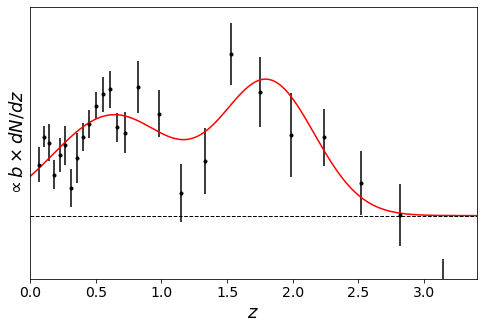

In [7]:
plt.figure(figsize=(8, 5))
ax = plt.gca()
ax.errorbar(dn['z'], dn['dNdz_b'], yerr=dn['dNdz_b_err'], fmt='k.')
zs = np.linspace(0, 4, 1024)
#ax.plot(zs, gaumix(zs, *(get_params(res3.x))), 'b-')
ax.plot(zs, gaumix(zs, *(get_params(res2.x))), 'r-')
ax.plot([0, 3.4], [0, 0], 'k--', lw=1)
ax.set_ylim([-100, 330])
ax.set_xlim([0, 3.4])
ax.tick_params(axis='both', labelsize=14)
ax.set_xlabel(r'$z$', fontsize=18)
ax.set_ylabel(r'$\propto b\times dN/dz$', fontsize=18)
ax.set_yticks([])
plt.savefig("dndz.png", bbox_inches='tight')

In [10]:
cosmo = ccl.CosmologyVanillaLCDM()
dndz_fid = (zs, gaumix(zs, *(get_params(res2.x))))
tg = ccl.NumberCountsTracer(cosmo, False, dndz=dndz_fid, bias=(zs, np.ones_like(zs)))
tk = ccl.CMBLensingTracer(cosmo, z_source=1100.)
clgg = ccl.angular_cl(cosmo, tg, tg, dc['l'])
clgk = ccl.angular_cl(cosmo, tg, tk, dc['l'])

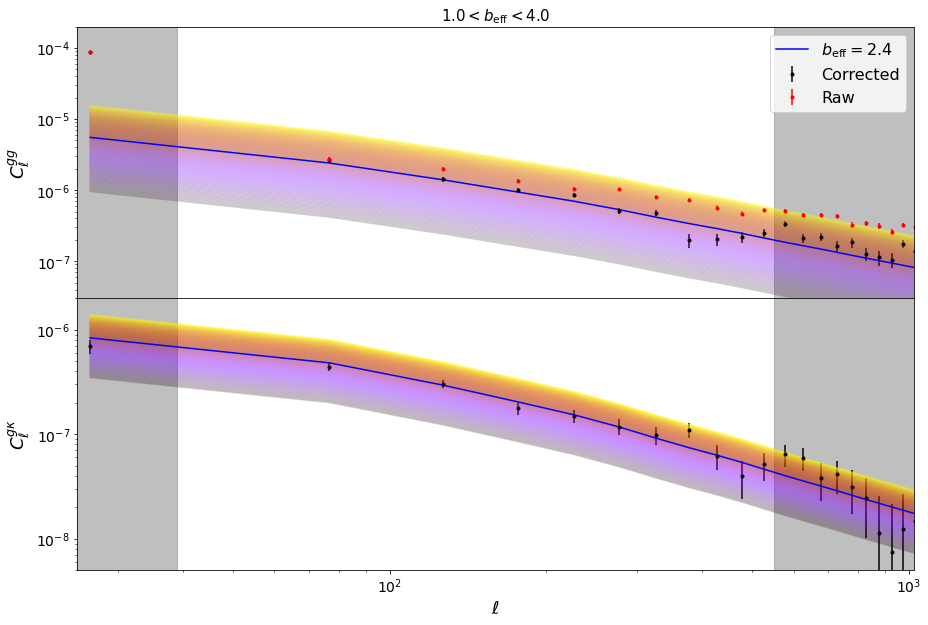

In [11]:
cmap = cm.get_cmap('gnuplot')
bs = np.linspace(1.0, 4.0, 128)

fig, axes = plt.subplots(2, 1,
                         figsize=(15, 10),
                         sharex=True)
plt.subplots_adjust(hspace=0)

axes[0].set_title(r'$1.0 < b_{\rm eff} < 4.0$', fontsize=15)
axes[0].errorbar(dc['l'], dc['Cl_gg']-dc['nl_gg'], yerr=dc['error_gg'], fmt='k.', label='Corrected')
axes[0].errorbar(dc['l'], dc['Cl_gg_raw']-dc['nl_gg'], yerr=dc['error_gg'], fmt='r.', label='Raw')
axes[1].errorbar(dc['l'], dc['Cl_gk'], yerr=dc['error_gk'], fmt='k.')
for i, b in enumerate(bs):
    c = cmap((i+0.5)/128)
    axes[0].plot(dc['l'], clgg*b**2, c=c, alpha=0.2) 
    axes[1].plot(dc['l'], clgk*b, c=c, alpha=0.2)
b = 2.4
axes[0].plot(dc['l'], clgg*b**2, 'b-', label=r'$b_{\rm eff} = 2.4$') 
axes[1].plot(dc['l'], clgk*b, 'b-')
axes[1].set_xlabel(r'$\ell$', fontsize=18)
axes[0].set_ylabel(r'$C^{gg}_\ell$', fontsize=18)
axes[1].set_ylabel(r'$C^{g\kappa}_\ell$', fontsize=18)
axes[0].set_ylim([3E-8, 2E-4])
axes[1].set_ylim([5E-9, 2E-6])
lhi = np.arange(1024)
for ax in axes:
    ax.loglog()
    ax.set_xlim([25, 1024])
    ax.fill_between(lhi, 0, 1, where=(lhi < 40) | (lhi > 550),
                    color='gray', alpha=0.5,
                    transform=ax.get_xaxis_transform())
    ax.tick_params(axis='both', labelsize=14)
axes[0].legend(fontsize=16)
plt.savefig("tomographer_test.png", bbox_inches='tight')

2.4222444866250674 0.03671924398604852
2.430405979895899 0.038635316761984236
2.3519857936289092 0.1129632483880911


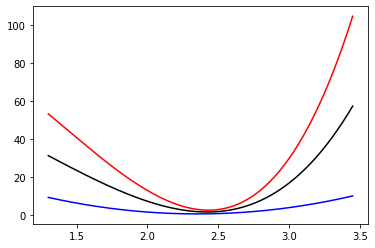

In [12]:
msk = (dc['l'] > 40) & (dc['l'] < 550)
data = np.array([(dc['Cl_gg']-dc['nl_gg'])[msk], dc['Cl_gk'][msk]])
err = np.array([dc['error_gg'][msk], dc['error_gk'][msk]])
temps = np.array([clgg[msk], clgk[msk]])
ndata = len(data[1])

def chi2_cl(beff, inc_gg=True, inc_gk=True):
    bs = np.array([beff**2, beff])
    theory = temps*bs[:, None]
    res = (data-theory)/err
    chi2 = 0
    if inc_gg:
        chi2 += np.sum(res[0]**2)
    if inc_gk:
        chi2 += np.sum(res[1]**2)
    return chi2

beffs = np.linspace(1.3, 3.45, 1024)
chi2_all = np.array([chi2_cl(b, inc_gg=True, inc_gk=True) for b in beffs])
chi2_gg = np.array([chi2_cl(b, inc_gg=True, inc_gk=False) for b in beffs])
chi2_gk = np.array([chi2_cl(b, inc_gg=False, inc_gk=True) for b in beffs])

def anachi2(chi2):
    bmean = np.average(beffs, weights=np.exp(-0.5*chi2))
    var = np.average((beffs-bmean)**2, weights=np.exp(-0.5*chi2))
    print(bmean, np.sqrt(var))
    return bmean, np.sqrt(var)

anachi2(chi2_all)
anachi2(chi2_gg)
anachi2(chi2_gk)

plt.plot(beffs, chi2_all/(2*ndata), 'k-')
plt.plot(beffs, chi2_gg/ndata, 'r-')
plt.plot(beffs, chi2_gk/ndata, 'b-')
